In [1]:
# functions nessersary 
import numpy as np
import math 

# Converts Euler angles ([rx, ry, rz] in deg) to a 3x3 rotation matrix
def EulerToRMat(Euler):

    sx = math.sin(Euler[0]);
    sy = math.sin(Euler[1]);
    sz = math.sin(Euler[2]);
    cx = math.cos(Euler[0]);
    cy = math.cos(Euler[1]);
    cz = math.cos(Euler[2]);

    RMat = np.eye(3);
    RMat[0,0] = cy*cz;
    RMat[0,1] = sx*sy*cz-cx*sz;
    RMat[0,2] = cx*sy*cz+sx*sz;
    RMat[1,0] = cy*sz;
    RMat[1,1] = sx*sy*sz+cx*cz;
    RMat[1,2] = cx*sy*sz-sx*cz;
    RMat[2,0] = -sy;
    RMat[2,1] = sx*cy;
    RMat[2,2] = cx*cy;

    return RMat

# Converts a 3x3 rotation matrix to a quaternion
def RMatToQuat(RMat):

    quat = np.zeros((4,1));

    # abs is to avoid rounding errors in the sqrt - it shouldn't be negative anyway
    quat[0] = 0.5 * math.sqrt(abs(1 + RMat[0,0] + RMat[1,1] + RMat[2,2]));

    if (RMat[2,1] - RMat[1,2] > 0):
        quat[1] = 0.5 * math.sqrt(abs(1 + RMat[0,0] - RMat[1,1] - RMat[2,2]));
    else:
        quat[1] = -0.5 * math.sqrt(abs(1 + RMat[0,0] - RMat[1,1] - RMat[2,2]));


    if (RMat[0,2] - RMat[2,0] > 0):
        quat[2] = 0.5 * math.sqrt(abs(1 - RMat[0,0] + RMat[1,1] - RMat[2,2]));
    else:
        quat[2] = -0.5 * math.sqrt(abs(1 - RMat[0,0] + RMat[1,1] - RMat[2,2]));

    if (RMat[1,0] - RMat[0,1] > 0):
        quat[3] = 0.5 * math.sqrt(abs(1 - RMat[0,0] - RMat[1,1] + RMat[2,2]));
    else:
        quat[3] = -0.5 * math.sqrt(abs(1 - RMat[0,0] - RMat[1,1] + RMat[2,2]));

    return quat

# caclulating difference in Quaternions angles 
def quatDiff(q1, q2):
        
    # Difference: qd = q2 * q1c (q1c = conjugate of q1 = inverse of q1)
    # qd = (w2 + i.x2 + j.y2 + k.z2)(w1 - i.x1 - j.y1 - k.z1)
    # qd = w1.w2 - i.x1.w2 - j.y1.w2 - k.z1.w2 + i.w1.x2 - i^2.x1.x2 - ij.y1.x2 - ik.z1.x2 + j.w1.y2 - ji.x1.y2 - j^2.y1.y2 - jk.z1.y2 + k.w1.z2 - ki.x1.z2 - kj.y1.z2 - k^2.z1.z2
    # qd(1) =  w1.w2 + x1.x2 + y1.y2 + z1.z2
    # qd(2) = -x1.w2 + w1.x2 - z1.y2 + y1.z2
    # qd(3) = -y1.w2 + z1.x2 + w1.y2 - x1.z2
    # qd(4) = -z1.w2 - y1.x2 + x1.y2 + w1.z2

    qd = np.zeros((4,1));
    qd[0] =  q1[0]*q2[0] + q1[1]*q2[1] + q1[2]*q2[2] + q1[3]*q2[3]
    qd[1] = -q1[1]*q2[0] + q1[0]*q2[1] - q1[3]*q2[2] + q1[2]*q2[3]
    qd[2] = -q1[2]*q2[0] + q1[3]*q2[1] + q1[0]*q2[2] - q1[1]*q2[3]
    qd[3] = -q1[3]*q2[0] - q1[2]*q2[1] + q1[1]*q2[2] + q1[0]*q2[3]

    a = 2 * np.arccos(np.float32(qd[0]))

    a = abs(a);

    return a, qd

# normalisation function between -1 and +1  
def normalise(x, min_val, max_val):

    # equation for normalisation 
    x_n = (2 * (x - min_val) / (max_val - min_val)) - 1

    return x_n 

In [3]:
## creating an environment class (child class to gym.Env) for the Ultrasound Robot
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import pybullet as p 
import pybullet_utils.bullet_client as bullet_client
import random
import math
import matplotlib.pyplot as plt
import time

class RightArmRobot(gym.Env):
    """
    Custom Environment that follows gym interface.
    """

    # (old comment) Because of google colab, we cannot implement the GUI ('human' render mode)
    metadata = {"render_modes": ["human", "rgb_array"], "simulation_fps": 50} # PyBullet simulation FPS

    def __init__(self, render_mode="human"):

        # calls constructor of parent class gym.Env         
        super(RightArmRobot, self).__init__()
        
        # setting up the render mode for visualisation 
        self.render_mode = render_mode

        # Initialize PyBullet client ID
        self._physics_client_id = -1  
        
        # initialsiing the action space as continous (action is angles of all 9 motorised joints) 
        self.action_space = spaces.Box(low=-1, high=1, shape=(20,), dtype=np.float32) # change to 20 once URDF is updated for 2 arms
        # initialising the observation space as continous (observation is cartesian coordiantes of final joint in the robot)
        self.observation_space = spaces.Box(low = -10, high = 10, shape=(10,), dtype=np.float32)

        # tolerance for goal completion (position)
        self.pos_tol = 0.02

        # tolerance for goal completion (orientation)
        self.orient_tol = 0.2

        # initalising step number 
        self.step_number = 0

        # initalising the episode number 
        self.episode_number = 0 

        # initalise the max step number 
        self.max_step_size = 100

        # collision number inialisation 
        self.collisions = 0

        # rest function called to properly initalise the 
        self.reset()

    def reset(self, seed=None, options=None):

        # re-initalisation of environment after truncation, termination or initalisation

        # reset step number and print
        self.step_number = 0

        # increase the episode number 
        self.episode_number += 1

        # initalising the prev Euclidean distance
        self.prev_Euclid_dist = 0

        # calls constructor of parent class gym.Env 
        super().reset(seed=seed, options=options)

        # random number generator to provide new target for the robot to move to (set limits)
        self.x_target1 = random.random()*(0.15 - -0.10) 
        self.y_target1 = random.random()*(0.65 - 0.3) + (0.3) 
        self.z_target1 = random.random()*(0.35 - 0.15) + (0.15) 
        self.pos_target1 = np.array([self.x_target1, self.y_target1, self.z_target1], dtype=np.float32)

        # position target for the second arm 
        self.x_target2 = random.random()*(0.15 - -0.10) 
        self.y_target2 = random.random()*(0.65 - 0.3) + (0.3) 
        self.z_target2 = random.random()*(0.35 - 0.15) + (0.15) 
        self.pos_target2 = np.array([self.x_target2, self.y_target2, self.z_target2], dtype=np.float32)

        # New ORIENTATION target (in Euler angles) for the robot to move to (set limits)
        self.x_euler_t1 = random.random()*(-0.785398 - -2.35619)
        self.y_euler_t1 = random.random()*(0.785398 - -0.785398)
        self.z_euler_t1 = random.random()*(math.pi - -math.pi)
        self.euler_t1 = np.array([self.x_euler_t1, self.y_euler_t1, self.z_euler_t1])

        # angle target for the second arm 
        self.x_euler_t2 = random.random()*(-0.785398 - -2.35619)
        self.y_euler_t2 = random.random()*(0.785398 - -0.785398)
        self.z_euler_t2 = random.random()*(math.pi - -math.pi)
        self.euler_t2 = np.array([self.x_euler_t2, self.y_euler_t2, self.z_euler_t2])

        # Converting the target Euler angles into Matrix 
        self.Mat_t1 = EulerToRMat(self.euler_t1)
        self.Mat_t2 = EulerToRMat(self.euler_t2)
        # Converting the target Matrix into Quaternion
        self.Quat_t1 = RMatToQuat(self.Mat_t1)
        self.Quat_t2 = RMatToQuat(self.Mat_t2)
        
        # setup PyBullet client 
        if self._physics_client_id < 0:
            # create BulletClient 
            if self.render_mode == "human":
                self._bullet_client = bullet_client.BulletClient(connection_mode=p.DIRECT)
            else:
                self._bullet_client = bullet_client.BulletClient()
            self._physics_client_id = self._bullet_client._client

        # setting up PyBullet simulation 
        self._bullet_client.resetSimulation()
        self._bullet_client.setGravity(0, 0, -9.8)
        self._bullet_client.setTimeStep(1.0 / self.metadata["simulation_fps"])

        # load robot 
        p.setAdditionalSearchPath(r"C:\Users\whows\OneDrive - King's College London\Documents\BEng project\Ultrasound project Git\Two_arm_Git")
        self.RightArmRobot = self._bullet_client.loadURDF("TwoArms_col.urdf",[0, 0, 0], useFixedBase=True)

        # check if loading of the robot was sucessful 
        if self.RightArmRobot < 0:
            raise FileNotFoundError("Failed to load kuka_3.urdf. Check the file path.")

        # Check the number of joints
        self.num_joints = self._bullet_client.getNumJoints(self.RightArmRobot)
        # print(self.num_joints)
        

        # Validate link index
        link_index = 9
        if link_index >= self.num_joints:
            raise IndexError(f"Invalid link index {link_index}. Max index is {self.num_joints - 1}.")

        # Get link state
        link_state = self._bullet_client.getLinkState(self.RightArmRobot, link_index)
        if link_state is None:
            raise RuntimeError(f"Failed to get link state for link {link_index}.")

        # Find and print link information (for debugging)
        #for i in range(num_joints):
             #joint_name = self._bullet_client.getJointInfo(self.RightArmRobot, i)[12].decode('utf-8')  # Get joint name
             #link_index = self._bullet_client.getJointInfo(self.RightArmRobot, i)[16] # Get link index
             #if link_index != -1: # if the joint has an associated link
                 #link_name = self._bullet_client.getLinkInfo(self.RightArmRobot,link_index)[0].decode('utf-8')
                #print(f"Joint {i}: {joint_name}, Link index: {link_index}, Link Name: {link_name}")

        # get the position of links of interst 
        link_index1 = 12
        link_index2 = self.num_joints - 1
        
        link_state1 = self._bullet_client.getLinkState(self.RightArmRobot, link_index1)
        link_state2 = self._bullet_client.getLinkState(self.RightArmRobot, link_index2)
        
        # extracting the x y z position 
        self.position1 = np.array(link_state1[0], dtype=np.float32)
        self.position2 = np.array(link_state2[0], dtype=np.float32)

        # extracting the orientation as a Quaternion
        self.orientation1 = np.array(link_state1[1], dtype=np.float32)
        self.orientation2 = np.array(link_state2[1], dtype=np.float32)
        
        # calculating initial distances from the targets 
        self.Euclid_dist1 = math.dist(self.position1, self.pos_target1)
        self.Euclid_dist2 = math.dist(self.position2, self.pos_target2)
        
        # calculating angular differences from targets 
        self.Quaternion_diff1 = quatDiff(self.orientation1, self.Quat_t1)
        self.Quat_diff_angle1 = self.Quaternion_diff1[0]
        self.Quat_diff_Q1 = self.Quaternion_diff1[1]

        self.Quaternion_diff2 = quatDiff(self.orientation2, self.Quat_t2)
        self.Quat_diff_angle2 = self.Quaternion_diff2[0]
        self.Quat_diff_Q2 = self.Quaternion_diff2[1]

        # normalising position such that observations are more easily computeable in RL neural networks
        # normalising target positions 
        self.x_target_n1 = normalise(self.x_target1, -0.10, 0.15)
        self.y_target_n1 = normalise(self.y_target1, 0.3, 0.65)
        self.z_target_n1 = normalise(self.z_target1, 0.15, 0.35)
        self.pos_target_n1 = np.array([self.x_target_n1, self.y_target_n1, self.z_target_n1], dtype=np.float32)

        self.x_target_n2 = normalise(self.x_target2, -0.10, 0.15)
        self.y_target_n2 = normalise(self.y_target2, 0.3, 0.65)
        self.z_target_n2 = normalise(self.z_target2, 0.15, 0.35)
        self.pos_target_n2 = np.array([self.x_target_n2, self.y_target_n2, self.z_target_n2], dtype=np.float32)
        
        # normalising actual positions 
        self.x_pos_n = normalise(self.position1[0], -0.10, 0.15)
        self.y_pos_n = normalise(self.position1[1], 0.3, 0.65)
        self.z_pos_n = normalise(self.position1[2], 0.15, 0.35)
        self.pos_n1 = np.array([self.x_pos_n, self.y_pos_n, self.z_pos_n], dtype=np.float32)
        self.pos_n2 = self.pos_n1
         
        
        # self.observation MUST be a numpy array 
        # observation is the euclidean distance, the quaternion difference, the target positions, the current positions, target orientation, current orientation 
        self.observation = np.concatenate([np.array([self.Euclid_dist1], dtype=np.float32), np.array([self.Euclid_dist2],  dtype=np.float32), np.array([self.Quat_diff_Q1], dtype=np.float32).flatten(), np.array([self.Quat_diff_Q2], dtype=np.float32).flatten()]).astype(np.float32)
        
        
        return self.observation, {}
        

    def step(self, action):

        # takes an action in a given state

        # updating the step counter each step and printing
        self.step_number += 1

        # inialise convergence of each arm
        self.arm_left_conv = False
        self.arm_right_conv = False

        # initalising the scaled action variable to have the dimensions of the actions 
        scaled_action = action

        # scale action by pi 
        for i in range(20):
            if (i == 0):
                scaled_action[i] = action[i] / 4
            else:
                scaled_action[i] = action[i] * np.pi 

        # applying dependent joint constraints to both arms  
        scaled_action[3] = -scaled_action[2]
        scaled_action[13] = -scaled_action[12]
        
        # Apply action to robot
        for i in range(20):  # iterating through all joints of both arms of the robot
            if (i == 1): # skip the non moving joint
                continue
            self._bullet_client.setJointMotorControl2(
                self.RightArmRobot, i, p.POSITION_CONTROL, targetPosition=scaled_action[i]
                )
            
        # use for loop for updating to ensure that the robot can move by the amount it needs to move 
        for _ in range(3):
            # Robots new position is updated in the simulation  
            self._bullet_client.stepSimulation()

        
        #link_index0 = 0
        #link_state0 = self._bullet_client.getLinkState(self.RightArmRobot, link_index0)
        #position0 = np.array(link_state0[0], dtype=np.float32)
        #print(position0)
        
        # Gives position of the final link of the 1st arm Robot in Cartesian space
        link_state1 = self._bullet_client.getLinkState(self.RightArmRobot, 10)
        
        # Position and orienatation are the observation to be changed 
        self.position1 = np.array(link_state1[0], dtype=np.float32)
        self.orientation1 = np.array(link_state1[1], dtype=np.float32)

        # Gives position of the final link of the 2nd arm Robot in Cartesian space
        link_state2 = self._bullet_client.getLinkState(self.RightArmRobot, 20)

        # Position and orientation are the observation to be changed 
        self.position2 = np.array(link_state2[0], dtype=np.float32)
        self.orientation2 = np.array(link_state2[1], dtype=np.float32)

        # normalising actual positions 
        self.x_pos_n1 = normalise(self.position1[0], -0.10, 0.15) # first arm position  
        self.y_pos_n1 = normalise(self.position1[1], 0.3, 0.65)
        self.z_pos_n1 = normalise(self.position1[2], 0.15, 0.35)

        self.x_pos_n2 = normalise(self.position2[0], -0.10, 0.15) # second arm position 
        self.y_pos_n2 = normalise(self.position2[1], 0.3, 0.65)
        self.z_pos_n2 = normalise(self.position2[2], 0.15, 0.35)
        
        self.pos_n1 = np.array([self.x_pos_n1, self.y_pos_n1, self.z_pos_n1], dtype=np.float32)
        self.pos_n2 = np.array([self.x_pos_n2, self.y_pos_n2, self.z_pos_n2], dtype=np.float32)

        # calculating the Euclidian distance for reward calculation
        self.Euclid_dist1 = math.dist(self.position1, self.pos_target1)
        self.Euclid_dist2 = math.dist(self.position2, self.pos_target2)
        self.Euclid_distT = [self.Euclid_dist1, self.Euclid_dist2]
        
        # calculating the Quaternion difference for first arm for reward calculation 
        self.Quaternion_diff1 = quatDiff(self.orientation1, self.Quat_t1)
        self.Quat_diff_angle1 = self.Quaternion_diff1[0].item()
        self.Quat_diff_Q1 = self.Quaternion_diff1[1]

        # calculating the Quaternion difference for second arm for reward calculation
        self.Quaternion_diff2 = quatDiff(self.orientation2, self.Quat_t2)
        self.Quat_diff_angle2 = self.Quaternion_diff2[0].item()
        self.Quat_diff_Q2 = self.Quaternion_diff2[1]

        # overall angle 
        self.Quat_diff_angleT = [self.Quat_diff_angle1, self.Quat_diff_angle2]

        # observation is the euclidean distance, the quaternion difference, the target positions, the current positions,target orientation, current orientation 
        self.observation = np.concatenate([np.array([self.Euclid_dist1], dtype=np.float32), np.array([self.Euclid_dist2],  dtype=np.float32), np.array([self.Quat_diff_Q1], dtype=np.float32).flatten(), np.array([self.Quat_diff_Q2], dtype=np.float32).flatten()]).astype(np.float32)
        
        # new observation stored in variable obs  
        obs = self.observation

        # normalising the Euclidean distance to 0-1 (dividing by maximum Euclidean distance)
        self.Euclid_dist_n1 = (self.Euclid_dist1 / 0.7533)
        self.Euclid_dist_n2 = (self.Euclid_dist2 / 0.7533)

        # normalising the angular difference to 0-1 (dividing by the radians)
        self.Quat_diff_angle_n1 = self.Quat_diff_angle1 / (2 * np.pi)
        self.Quat_diff_angle_n2 = self.Quat_diff_angle2 / (2 * np.pi)
        
        # calculating the reward (sum of the Euclidean distance and the Quaternion difference)
        self.rew_left = - (self.Euclid_dist_n1 + self.Quat_diff_angle_n1)
        self.rew_right = - (self.Euclid_dist_n2 + self.Quat_diff_angle_n2)
        reward = self.rew_left + self.rew_right
        
        # collect as a prev Euclidean Distance 
        self.prev_Euclid_dist = self.Euclid_dist1

        # collison criteria  
        contact_points = self._bullet_client.getContactPoints(bodyA=self.RightArmRobot)
        if len(contact_points) > 0:
            reward -= 100 
            self.collisions += 1
            print("Collision")
            self.rew_indv = [self.rew_left, self.rew_right]
            terminated = True

        # convergence criteria 
        if ((self.Euclid_dist1 < self.pos_tol) and (self.Quat_diff_angle1 < self.orient_tol) and (self.arm_left_conv == False)):
            # large reward for convergence 
            reward += 240
            self.rew_left += 240
            self.arm_left_conv = True 

        if ((self.Euclid_dist2 < self.pos_tol) and (self.Quat_diff_angle2 < self.orient_tol) and (self.arm_right_conv == False)):
            # large reward for convergence
            reward += 240
            self.rew_right += 240 
            self.arm_right_conv = True

        if ((self.Euclid_dist1 < self.pos_tol) and (self.Quat_diff_angle1 < self.orient_tol) and (self.Euclid_dist2 < self.pos_tol) and (self.Quat_diff_angle2 < self.orient_tol)):
            # large reward for termination 
            reward += 500 
            self.rew_indv = [self.rew_left, self.rew_right]
            terminated = True 

        else:
            terminated = False 
        
        # truncation criteria
        if (self.step_number < self.max_step_size):          
            truncated = False
        else:
            self.rew_indv = [self.rew_left, self.rew_right]
            truncated = True 

        self.rew_indv = [self.rew_left, self.rew_right]
            
        # updating the info dictionary 
        info = {"Truncated":truncated,"Terminated":terminated,"Observations":obs,"EuclidDist":self.Euclid_distT,"AngleDiff":self.Quat_diff_angleT,"Collisions":self.collisions,"LeftArmConv":self.arm_left_conv,"RightArmConv":self.arm_right_conv,"RewardsIndv":self.rew_indv}            
        
        # returning all step variables in a tuple 
        return obs, reward, terminated, truncated, info

In [4]:
# defining the custom callback 
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.evaluation import evaluate_policy

class CustomCallback(BaseCallback):
    
    # initalisation of callback 
    def __init__(self, log_dir=None, verbose: int = 0):
        super().__init__(verbose)
        
        # initalisation of variables 
        self.timesteps = 0
        self.cum_rewards = 0
        self.episode_rewards = []
        self.episode_rewards_L = []
        self.episode_rewards_R = []
        self.number_of_episodes = 0
        self.log_dir = log_dir
        self.terminations = 0
        self.episode_timesteps = 0
        self.episode_termination = []
        self.final_Euclid_dists = []
        self.final_Euclid_dists1 = []
        self.final_Euclid_dists2 = []
        self.final_Quat_diffs = []
        self.final_Quat_diffs1 = []
        self.final_Quat_diffs2 = [] 
        self.change_Quat_diffs1 = []
        self.change_Quat_diffs2 = []
        self.mean_rewards = []
        self.std_rewards = [] 
        self.num_term_per_100 = 0
        self.num_term_per_100_L = []
        self.arm_left_conv = 0
        self.arm_right_conv = 0
        self.cum_rewards_L = 0
        self.cum_rewards_R = 0
        
    def _on_step(self) -> bool:

        # extracting info dictionary 
        info = self.locals["infos"][0]

        # extracting the Euclidean distance 
        Euclid_dist = info.get("EuclidDist")
        Euclid_dist1 = Euclid_dist[0]
        Euclid_dist2 = Euclid_dist[1] 
        Quat_diff = info.get("AngleDiff")
        Quat_diff1 = Quat_diff[0]
        Quat_diff2 = Quat_diff[1]
        
        # checking to see if it is the first timestep 
        if (self.episode_timesteps == 0):
            self.initial_Euclid_dist1 = Euclid_dist1
            self.initial_Euclid_dist2 = Euclid_dist2
            self.initial_Quat_diff1 = Quat_diff1
            self.initial_Quat_diff2 = Quat_diff2
        
        # update the timestep counter
        self.timesteps += 1
        self.episode_timesteps += 1

        # Access the "dones" array, which contains termination flags
        if "dones" in self.locals:
            done = self.locals["dones"][0]  # Extract first element (assuming non-parallel env)
        else:
            raise KeyError("Missing 'dones' in self.locals. Check environment compatibility.")

        # see whether the episode has finished  
        if done:
            
            # appending the episode number counter 
            self.number_of_episodes += 1
            # appending the episode reward counters
            self.episode_rewards.append(self.cum_rewards)
            self.episode_rewards_L.append(self.cum_rewards_L)
            self.episode_rewards_R.append(self.cum_rewards_R)
            # resetting the cumulative reward counters to 0 
            self.cum_rewards = 0
            self.cum_rewards_L = 0
            self.cum_rewards_R = 0
            self.episode_timesteps = 0

            # seeing if eithier arm reached the targets and update
            if info.get("LeftArmConv") == True:
                self.arm_left_conv += 1

            if info.get("RightArmConv") == True:
                self.arm_right_conv += 1

            # recording the final Euclidean distances
            self.final_Euclid_dists1.append(Euclid_dist1)
            self.final_Euclid_dists2.append(Euclid_dist2)
            self.final_Euclid_dists.append(Euclid_dist1 + Euclid_dist2)

            # recording the final Quaternion differences 
            self.final_Quat_diffs1.append(Quat_diff1) 
            self.final_Quat_diffs2.append(Quat_diff2)
            self.final_Quat_diffs.append(Quat_diff1 + Quat_diff2)
            
            # checking to see if robot reached target
            info = self.locals["infos"][0]
            if info.get("Terminated") is True:
                self.terminations += 1 
                self.num_term_per_100 += 1
                self.episode_termination.append(self.number_of_episodes)

            # checking if 100,000 timesteps is reached 
            if (self.timesteps % 100000 == 0): 
                # evaluating policy 
                mean_reward, std_reward = evaluate_policy(self.model, self.training_env, n_eval_episodes=100)
                self.mean_rewards.append(mean_reward)
                self.std_rewards.append(std_reward)
                self.num_term_per_100_L.append(self.num_term_per_100)
                

        
        # record the reward of the step taken 
        reward = self.locals["rewards"]
        self.cum_rewards += reward
        self.indv_rew = info.get("RewardsIndv")
        self.left_rew = self.indv_rew[0]
        self.right_rew = self.indv_rew[1]
        self.cum_rewards_L += self.left_rew
        self.cum_rewards_R += self.right_rew 
    
            
        return True 

    def _on_training_end(self) -> None:

        # Save episode rewards to a text file
        #with open("trial1.txt", "w") as file:
        #    for reward in self.episode_rewards:
        #        file.write(f"{reward}\n")

        # extracting info dictionary 
        info = self.locals["infos"][0]

        # save rewards to text file
        np.savetxt('reward_j.txt', np.array(self.episode_rewards))

        # save Left arm rewards to text file 
        np.savetxt('reward_L.txt', np.array(self.episode_rewards_L))

        # save Right arm rewards to text file
        np.savetxt('reward_R.txt', np.array(self.episode_rewards_R))

        # save final Euclidean distance as text file
        np.savetxt('fEuclid_j.txt', np.array(self.final_Euclid_dists))

        # save final Left Euclidean distance as text file 
        np.savetxt('fEuclid_L_j.txt', np.array(self.final_Euclid_dists1))

        # save final Right Euclidean distance as text file 
        np.savetxt('fEuclid_R_j.txt', np.array(self.final_Euclid_dists2))

        # save final Quaternion diff
        np.savetxt('fQuat_j.txt', np.array(self.final_Quat_diffs))

        # save final Quaternion diff (Left) as text file 
        np.savetxt('fQuat_L_j.txt', np.array(self.final_Quat_diffs1))

        # save final Quaternion diff (Right) as text file 
        np.savetxt('fQuat_R_j.txt', np.array(self.final_Quat_diffs2))

        # save mean reward values
        np.savetxt('mreward_j.txt', np.array(self.mean_rewards))

        # save std reward values 
        np.savetxt('std_rew_j.txt', np.array(self.std_rewards))

        # save number of terms per 100,000
        np.savetxt('num_term_per_100_j', np.array(self.num_term_per_100_L))
        
        # printing the number of terminations and the number of total episodes
        print("Number of episodes: ", self.number_of_episodes)
        print("Number of terminations: ", self.terminations)
        print("Number of collisions: ", info.get("Collisions"))
        print("Number of Left Arm Convergences: ", self.arm_left_conv)
        print("Number of Right Arm Convergences: ", self.arm_right_conv)

        # plotting graphs
        plt.figure(figsize=(15,5))

        # rewards vs episode number 
        plt.subplot(2,3,1)
        plt.plot(self.episode_rewards)
        plt.xlabel("Number of Episodes")
        plt.ylabel("Cumulative Reward")
        plt.title("Cummalative Rewards VS Episode Number")

        # final Euclidean distance vs episode number 
        plt.subplot(2,3,2)
        plt.plot(self.final_Euclid_dists1)
        plt.xlabel("Number of Episodes")
        plt.ylabel("Final Euclidean Distance (m)")
        plt.title("Final Euclidean Distance (L) VS Episode Number")

        # change in Euclidean distance vs episode number 
        plt.subplot(2,3,3)
        plt.plot(self.final_Euclid_dists2)
        plt.xlabel("Number of Episodes")
        plt.ylabel("Final Euclidean Distance (m)")
        plt.title("Final Euclidean Distance (R) VS Episode Number")

        # final Quaternion difference vs episode number 
        plt.subplot(2,3,4)
        plt.plot(self.final_Quat_diffs1)
        plt.xlabel("Number of Episodes")
        plt.ylabel("Final Quaternion Difference (rad)")
        plt.title("Final Quaternion Difference (L) VS Episode Number")

        # change in Quaternion Difference vs episode number 
        plt.subplot(2,3,5)
        plt.plot(self.final_Quat_diffs2)
        plt.xlabel("Number of Episodes")
        plt.ylabel("Final Quaternion Difference (rad)")
        plt.title("Final Quaternion Difference (R) VS Episode Number")

        plt.subplot(2,3,6)
        plt.plot(self.cum_rewards_L)
        plt.xlabel("Number of Episodes")
        plt.ylabel("Rewards")
        plt.title("Rewards (Left Arm) VS Episode Number")

        plt.tight_layout()
        plt.show

In [5]:
# wrapping environment 
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
import os

# instantating arrayy containing the mean rewards and standard deviation to be computed at the end of each set of 100,000 steps 
mean_rewards_arr = np.array(range(10))
std_rewards_arr = np.array(range(10))

# instantiate the robot arm custom environment and wrap with a monitor wrapper  
env = Monitor(RightArmRobot())


In [6]:
# checking the environment 
# If the environment don't follow the interface, an error will be thrown
check_env(env, warn=True)


Number of episodes:  35
Number of terminations:  0
Number of collisions:  0
Number of Left Arm Convergences:  0
Number of Right Arm Convergences:  0


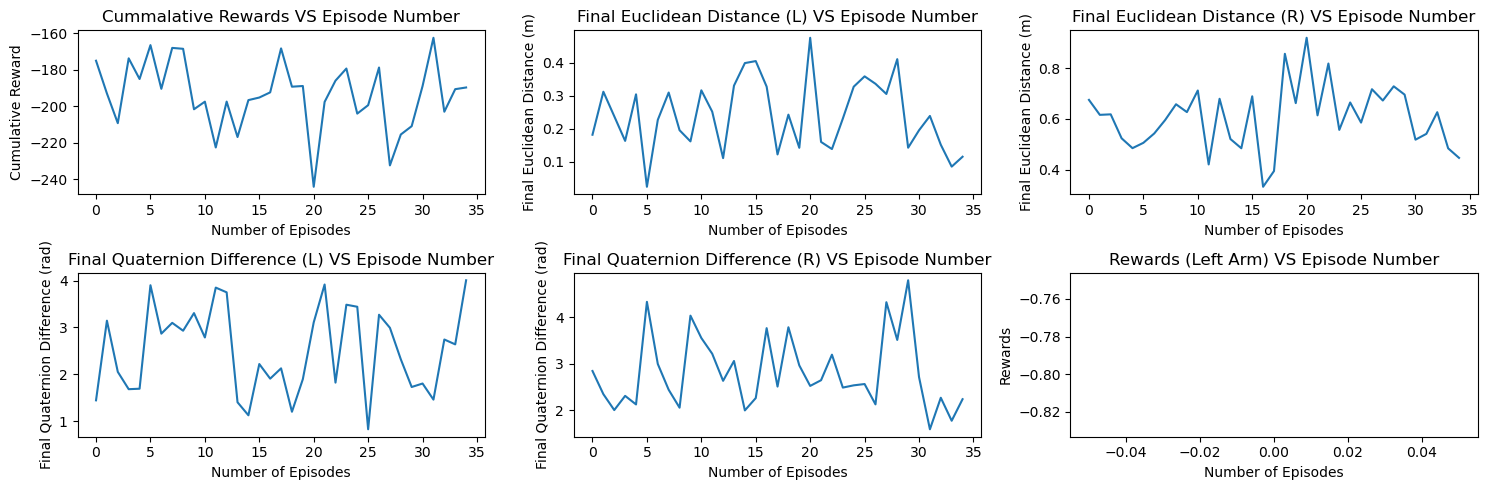

In [11]:
# training Agent 
from stable_baselines3 import SAC
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Instantiate the callback
plotting_callback = CustomCallback()

# training SAC model for the custom environment  
model = SAC("MlpPolicy", env, verbose=0).learn(total_timesteps=3500, callback=plotting_callback)

In [ ]:
# saving the model and replay buffer after the training 
model.save("TwoArmModel")
model.save_replay_buffer("TwoArmReplayBuffer")